# nomoly Detection with Time Series Exercies

### **Exercises**
file name: time_series_anomaly_detection.py or time_series_anomaly_detection.ipynb

- The dataset for these exercises lives in the Codeup Data Science MySQL Server. The database name is curriculum_logs.

**Hint:** You will need to explore the database and significantly adjust your acquisition step (yay SQL!)

- Label students by the program they are in.
- Is it possible to identify the user_id of a staff member?
- Identify students who are accessing our curriculum pages beyond the end of their time at Codeup.
- Identify students who present anomalous activity using the Bollinger Band method, but reduce K to 2.
- Plot the access activity of these students.

**BONUS:** Identify users who are viewing both the web dev and data science curriculum

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import metrics

import env
import os

import warnings
warnings.filterwarnings("ignore")

plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)

In [2]:
# let's pull the dataset from the sql server
url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/curriculum_logs'
query = '''
    SELECT date, time, path, user_id, cohort_id, program_id, ip, name, slack, start_date, end_date, created_at, updated_at
    FROM logs
    JOIN cohorts on logs.cohort_id = cohorts.id
    '''

if os.path.isfile('curriculum_logs.csv'):
    df = pd.read_csv('curriculum_logs.csv', index_col = 0)  
else:
    df = pd.read_sql(query, url)
    df.to_csv('curriculum_logs.csv')
    
df.head()


,date,time,path,user_id,cohort_id,program_id,ip,name,slack,start_date,end_date,created_at,updated_at
0,2018-01-26,09:55:03,/,1,8.0,1,97.105.19.61,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26
1,2018-01-26,09:56:02,java-ii,1,8.0,1,97.105.19.61,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,1,97.105.19.61,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,1,97.105.19.61,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,2,97.105.19.61,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 847330 entries, 0 to 847329
Data columns (total 13 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   date        847330 non-null  object 
 1   time        847330 non-null  object 
 2   path        847329 non-null  object 
 3   user_id     847330 non-null  int64  
 4   cohort_id   847330 non-null  float64
 5   program_id  847330 non-null  int64  
 6   ip          847330 non-null  object 
 7   name        847330 non-null  object 
 8   slack       847330 non-null  object 
 9   start_date  847330 non-null  object 
 10  end_date    847330 non-null  object 
 11  created_at  847330 non-null  object 
 12  updated_at  847330 non-null  object 
dtypes: float64(1), int64(2), object(10)
memory usage: 90.5+ MB


In [4]:
# let's look at the nulls
df.isna().sum()

date          0
time          0
path          1
user_id       0
cohort_id     0
program_id    0
ip            0
name          0
slack         0
start_date    0
end_date      0
created_at    0
updated_at    0
dtype: int64

In [5]:
# let's drop the nulls
df.dropna(inplace=True)

In [6]:
# let's drop the nulls
df.isna().sum()

date          0
time          0
path          0
user_id       0
cohort_id     0
program_id    0
ip            0
name          0
slack         0
start_date    0
end_date      0
created_at    0
updated_at    0
dtype: int64

In [7]:
# check for dulicates
df.duplicated().sum()

3518

In [8]:
# check duplicated records
df[df.duplicated(keep=False)][10:20] 

,date,time,path,user_id,cohort_id,program_id,ip,name,slack,start_date,end_date,created_at,updated_at
2949,2018-01-31,16:51:06,javascript-i/arrays/manipulating,44,22.0,2,97.105.19.61,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10
2950,2018-01-31,16:51:06,javascript-i/arrays/manipulating,44,22.0,2,97.105.19.61,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10
6023,2018-02-06,15:14:01,html-css,4,22.0,2,97.105.19.61,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10
6024,2018-02-06,15:14:01,html-css,4,22.0,2,97.105.19.61,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10
6589,2018-02-07,17:27:34,java-iii,76,18.0,2,216.177.181.227,Pinnacles,#pinnacles,2017-03-27,2017-07-20,2017-03-28 00:33:12,2017-03-28 00:33:12
6590,2018-02-07,17:27:34,java-iii,76,18.0,2,216.177.181.227,Pinnacles,#pinnacles,2017-03-27,2017-07-20,2017-03-28 00:33:12,2017-03-28 00:33:12
8234,2018-02-12,13:40:13,jquery/events,11,1.0,1,97.105.19.61,Arches,#arches,2014-02-04,2014-04-22,2016-06-14 19:52:26,2016-06-14 19:52:26
8235,2018-02-12,13:40:13,jquery/events,11,1.0,1,97.105.19.61,Arches,#arches,2014-02-04,2014-04-22,2016-06-14 19:52:26,2016-06-14 19:52:26
8549,2018-02-12,16:53:10,jquery/essential-methods/attributes-and-css,3,22.0,2,97.105.19.61,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10
8551,2018-02-12,16:53:10,jquery/essential-methods/attributes-and-css,3,22.0,2,97.105.19.61,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10


## Takeaway
- There are 3518 records duplicated
    - we can drop them

In [9]:
# removing duplicate rows and show shape
print(f'before duplicate drop num of records = {df.shape[0]}')
df = df.drop_duplicates(keep='first')
print(f'aftert duplicate drop num of records = {df.shape[0]}')

before duplicate drop num of records = 847329
aftert duplicate drop num of records = 843811


In [10]:
# concatenate and change date type columns to the respective type 
df['date_time'] = df.date + ' ' + df.time
df.date_time = pd.to_datetime(df.date_time, format = '%Y-%m-%d %H:%M:%S')
df.start_date = pd.to_datetime(df.start_date)
df.end_date = pd.to_datetime(df.end_date)
df.created_at = pd.to_datetime(df.created_at)

# set the index
df = df.set_index(df.date_time)

# let's rename some columns
df.rename(columns = {'path':'endpoint', 'ip':'source_ip'}, inplace = True)




# 1
Label Students by Program

In [11]:
df.sample(3)

,date,time,endpoint,user_id,cohort_id,program_id,source_ip,name,slack,start_date,end_date,created_at,updated_at,date_time
date_time,,,,,,,,,,,,,,
2020-05-04 14:38:40,2020-05-04,14:38:40,java-iii/servlets,565,53.0,2,66.69.44.184,Fortuna,#fortuna,2020-01-13,2020-06-23,2020-01-13 21:17:08,2020-01-13 21:17:08,2020-05-04 14:38:40
2020-08-07 18:01:45,2020-08-07,18:01:45,spring/fundamentals/views,523,52.0,2,99.147.238.134,Europa,#europa,2019-11-04,2020-04-17,2019-11-04 18:27:07,2019-11-04 18:27:07,2020-08-07 18:01:45
2020-02-26 08:07:53,2020-02-26,08:07:53,jquery,562,53.0,2,97.105.19.58,Fortuna,#fortuna,2020-01-13,2020-06-23,2020-01-13 21:17:08,2020-01-13 21:17:08,2020-02-26 08:07:53


In [12]:
# add program name to dataframe
df['program_name'] = df.program_id.map({1: 'full_stack_php',
                                        2: 'full_stack_java',
                                        3: 'data_science',
                                        4: 'front_end'})

In [13]:
df.sample(3)

,date,time,endpoint,user_id,cohort_id,program_id,source_ip,name,slack,start_date,end_date,created_at,updated_at,date_time,program_name
date_time,,,,,,,,,,,,,,,
2020-07-09 06:15:38,2020-07-09,06:15:38,javascript-i,671,58.0,2,24.243.67.104,Hyperion,#hyperion,2020-05-26,2020-11-10,2020-05-26 19:22:44,2020-05-26 19:22:44,2020-07-09 06:15:38,full_stack_java
2020-11-23 09:17:20,2020-11-23,09:17:20,appendix/further-reading/java/intellij-tomcat-...,712,61.0,2,71.159.247.210,Bash,#bash,2020-07-20,2021-01-21,2020-07-20 19:04:00,2020-09-30 15:54:46,2020-11-23 09:17:20,full_stack_java
2019-11-25 14:15:14,2019-11-25,14:15:14,javascript-i/introduction,524,52.0,2,97.105.19.58,Europa,#europa,2019-11-04,2020-04-17,2019-11-04 18:27:07,2019-11-04 18:27:07,2019-11-25 14:15:14,full_stack_java


# 2
Is it possible to identify the user_id of a staff member?

In [14]:
# create and array of 
df[df.name == 'Staff'].user_id.unique()

array([ 53, 314,  40,  64,  11, 211,   1, 312, 146, 248, 370, 397, 404,
       257, 428, 461,  37, 514, 539, 545, 546, 572, 315,  41, 592, 618,
       620, 521, 652, 502, 653, 480, 738, 742, 745, 813, 430, 816, 581,
       854, 855, 744, 893, 148, 894, 513, 630, 308, 951, 953, 980])

# 3
Identify students who are accessing our curriculum pages beyond the end of their time at Codeup.

In [15]:
# create a data frame for only students 
students = df[df['name'] != 'Staff']

In [16]:
students.sample(3)

,date,time,endpoint,user_id,cohort_id,program_id,source_ip,name,slack,start_date,end_date,created_at,updated_at,date_time,program_name
date_time,,,,,,,,,,,,,,,
2020-09-28 13:32:03,2020-09-28,13:32:03,capstone/workbook,656,58.0,2,73.34.158.193,Hyperion,#hyperion,2020-05-26,2020-11-10,2020-05-26 19:22:44,2020-05-26 19:22:44,2020-09-28 13:32:03,full_stack_java
2018-08-29 09:56:38,2018-08-29,09:56:38,javascript-i/introduction/primitive-types,226,25.0,2,104.237.80.70,Wrangell,#wrangell,2018-07-23,2018-11-29,2018-07-23 15:02:25,2018-07-23 15:02:25,2018-08-29 09:56:38,full_stack_java
2019-06-19 11:49:49,2019-06-19,11:49:49,html-css/css-i/box-model,415,32.0,2,97.105.19.58,Betelgeuse,#betelgeuse,2019-05-28,2019-10-08,2019-05-28 18:41:05,2019-05-28 18:41:05,2019-06-19 11:49:49,full_stack_java


In [17]:
# get a list of user_id that make api calls after end_data
students_accessing_after_graduation = students[students['date'] > students['end_date']].user_id.unique()

In [18]:
# there are 556 students accessing curriculum after graduation
students_accessing_after_graduation.shape

(565,)

In [19]:
students_accessing_after_graduation

array([  1,  11,  21,  26,  37,  40,  50,  51,  53,  60,  64,  66,  67,
        68,  69,  70,  71,  72,  75,  76,  77,  80,  81,  82,  83,  84,
        85,  87,  90,  91,  92,  93,  94,  95,  96,  97,  98, 101, 102,
        16,  42,  41,  17,  22,  15, 104,  47,  57,  10, 105, 106,  28,
       107,  65,  52,  33,  56, 108,  27,  38,  36, 109, 110, 112, 113,
       114, 115, 139, 140, 141, 143, 144, 146, 147, 148, 149, 150, 151,
       152, 153, 156, 161, 162, 163, 164, 165, 167, 168, 169, 170, 172,
       173, 174, 175, 177, 178, 179,  29,  19, 180,   6,  99,  43,  31,
         7, 181, 138,  35, 142,   5, 155, 154,  88, 209, 210,  18,   3,
        20, 118, 211, 212, 214, 216, 217, 131, 135, 128, 127, 124, 130,
       159,  12, 145, 241, 242, 136, 157, 171, 123,  25, 134, 119, 243,
       244, 245, 246, 160, 248, 252, 254, 255, 120, 257, 279, 280, 281,
        14, 253, 188, 186, 283, 184, 215, 278, 183, 204, 193, 195, 197,
       249, 206, 284, 121, 201, 285, 286, 311, 190, 312, 116, 20

# 4 
Identify students who present anomalous activity using the Bollinger Band method, but reduce K to 2.

In [20]:
pages = df['endpoint'].resample('d').count()
pages.head()

date_time
2018-01-26    531
2018-01-27    230
2018-01-28    168
2018-01-29    783
2018-01-30    613
Freq: D, Name: endpoint, dtype: int64

<AxesSubplot:xlabel='date_time'>

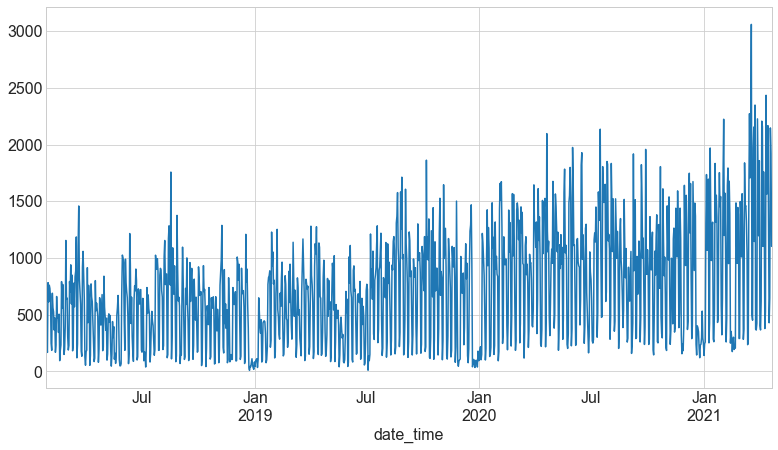

In [21]:
pages.plot()

In [22]:
# Set multiple EMA

# 7 day EMA
ema_7d = pages.ewm(span=7).mean()
# 14 days EMA
ema_14d = pages.ewm(span=14).mean()
# 30 days EMA
ema_30d = pages.ewm(span=30).mean()
# 90 days EMA
ema_90d = pages.ewm(span=90).mean()

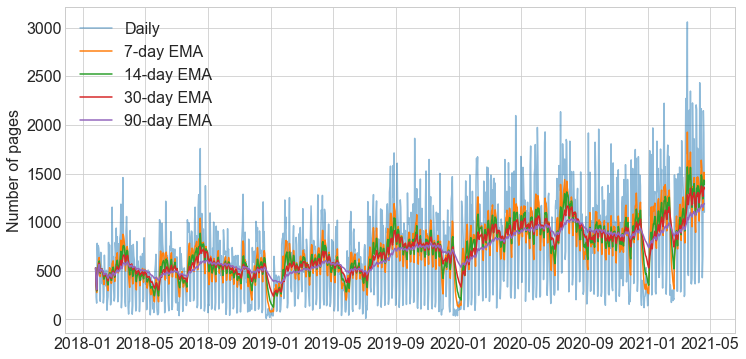

In [23]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(pages.index, pages, label='Daily', alpha=.5)

ax.plot(pages.index, ema_7d, label = '7-day EMA')
ax.plot(pages.index, ema_14d, label = '14-day EMA')
ax.plot(pages.index, ema_30d, label = '30-day EMA')
ax.plot(pages.index, ema_90d, label = '90-day EMA')

ax.legend(loc='best')
ax.set_ylabel('Number of pages')

plt.show()

In [24]:
# bandwidths

# set the window span
span = 30

# compute midband
midband = pages.ewm(span=span).mean()

# compute exponential stdev
stdev = pages.ewm(span=span).std()

# compute upper and lower bands
upper_band = midband + stdev*3
lower_band = midband - stdev*3

In [25]:
# concatenate ub and lb together into one df, bb
bb = pd.concat([upper_band, lower_band], axis=1)

bb.columns = ['upper_band', 'lower_band']
bb.head()

,upper_band,lower_band
date_time,,
2018-01-26,NaN,NaN
2018-01-27,1014.000757,-263.034090
2018-01-28,876.519090,-273.195136
2018-01-29,1311.153723,-442.577438
2018-01-30,1262.556763,-312.657929


In [26]:
# create dataframe with pages, midband, upper band and lower band
my_df = pd.concat([pages, midband, bb], axis=1)
my_df.columns = ['pages', 'midband', 'upper_band', 'lower_band']
my_df.head()

,pages,midband,upper_band,lower_band
date_time,,,,
2018-01-26,531,531.000000,NaN,NaN
2018-01-27,230,375.483333,1014.000757,-263.034090
2018-01-28,168,301.661977,876.519090,-273.195136
2018-01-29,783,434.288143,1311.153723,-442.577438
2018-01-30,613,474.949417,1262.556763,-312.657929


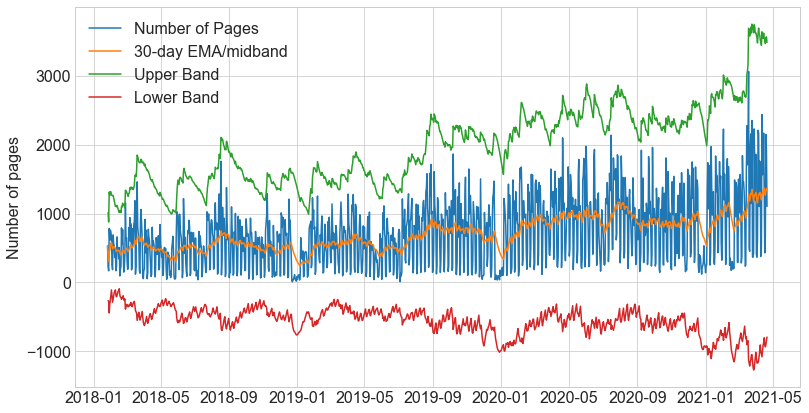

In [27]:
# plot bands
fig, ax = plt.subplots()

ax.plot(my_df.index, my_df.pages, label='Number of Pages')

ax.plot(my_df.index, my_df.midband, label = '30-day EMA/midband')
ax.plot(my_df.index, my_df.upper_band, label = 'Upper Band')
ax.plot(my_df.index, my_df.lower_band, label = 'Lower Band')

ax.legend(loc='best')
ax.set_ylabel('Number of pages')

plt.show()

In [28]:
# calculate and attach %b as pct_b into my_df
my_df['pct_b'] = (my_df['pages'] - my_df['lower_band'])/(my_df['upper_band'] - my_df['lower_band'])

In [29]:
# to look for anomallies, we will search for %b values > 
my_df[my_df['pct_b']>1]

,pages,midband,upper_band,lower_band,pct_b
date_time,,,,,


## Takeaway 
- There are no anomalies 

# 5
Plot the access activity of these students.

In [30]:
#########################################################################
###                  Create Functions to  find anomalies             ####
#########################################################################

def acquire_logs(user=env.user, password=env.password, host=env.host):
    '''
    This function queries the Codeup MySQL curriculum_logs database and returns a dataframe
    '''
    url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/curriculum_logs'
    query = '''
    SELECT date,
           path as endpoint,
           user_id,
           cohort_id,
           ip as source_ip
    FROM logs;
    '''
    df = pd.read_sql(query, url)
    return df

def one_user_df_prep(df, user):
    '''
    This function returns a dataframe consisting of data for only a single defined user
    '''
    df = df[df.user_id == user]
    df.date = pd.to_datetime(df.date)
    df = df.set_index(df.date)
    pages_one_user = df['endpoint'].resample('d').count()
    return pages_one_user

def compute_pct_b(pages_one_user, span, weight, user):
    '''
    This function adds the %b of a bollinger band range for the page views of a single user's log activity
    '''
    # Calculate upper and lower bollinger band
    midband = pages_one_user.ewm(span=span).mean()
    stdev = pages_one_user.ewm(span=span).std()
    ub = midband + stdev*weight
    lb = midband - stdev*weight
    
    # Add upper and lower band values to dataframe
    bb = pd.concat([ub, lb], axis=1)
    
    # Combine all data into a single dataframe
    my_df = pd.concat([pages_one_user, midband, bb], axis=1)
    my_df.columns = ['pages_one_user', 'midband', 'ub', 'lb']
    
    # Calculate percent b and relevant user id to dataframe
    my_df['pct_b'] = (my_df['pages_one_user'] - my_df['lb'])/(my_df['ub'] - my_df['lb'])
    my_df['user_id'] = user
    return my_df

def plot_bands(my_df, user):
    '''
    This function plots the bolliger bands of the page views for a single user
    '''
    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(my_df.index, my_df.pages_one_user, label='Number of Pages, User: '+str(user))
    ax.plot(my_df.index, my_df.midband, label = 'EMA/midband')
    ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
    ax.plot(my_df.index, my_df.lb, label = 'Lower Band')
    ax.legend(loc='best')
    ax.set_ylabel('Number of Pages')
    plt.show()

def find_anomalies(df, user, span, weight, plot=False):
    '''
    This function returns the records where a user's daily activity exceeded the upper limit of a bollinger band range
    '''
    
    # Reduce dataframe to represent a single user
    pages_one_user = one_user_df_prep(df, user)
    
    # Add bollinger band data to dataframe
    my_df = compute_pct_b(pages_one_user, span, weight, user)
    
    # Plot data if requested (plot=True)
    if plot:
        plot_bands(my_df, user)
    
    # Return only records that sit outside of bollinger band upper limit
    return my_df[my_df.pct_b>1]

In [31]:
df = acquire_logs()
df.head()

,date,endpoint,user_id,cohort_id,source_ip
0,2018-01-26,/,1,8.0,97.105.19.61
1,2018-01-26,java-ii,1,8.0,97.105.19.61
2,2018-01-26,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,javascript-i/conditionals,2,22.0,97.105.19.61


In [32]:
#Use function in a loop examining all users
span = 30
weight = 3.5

anomalies = pd.DataFrame()
for u in list(df.user_id.unique()):
    user_df = find_anomalies(df, u, span, weight)
    anomalies = pd.concat([anomalies, user_df], axis=0)

<AxesSubplot:xlabel='date'>

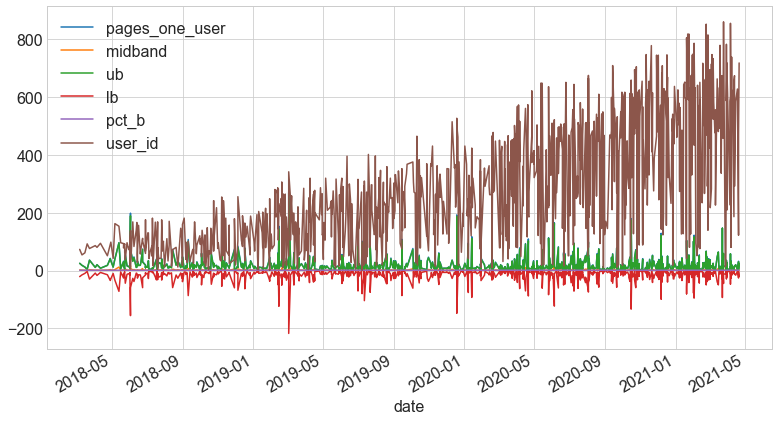

In [33]:
anomalies.plot()

# BONUS: 
Identify users who are viewing both the web dev and data science curriculum
